<a href="https://colab.research.google.com/github/nunocesarsa/SENSECO_School_2021/blob/main/DSRP_Lunch_Inverting_RTM_Simulations_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading up general usage libraries

In [ ]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

#this is the swarm optimization package
!pip install --upgrade pyswarm

#spotpy
!pip install spotpy

#bayesian optimization packages
!pip install bayesian-optimization

#genetic algorithsm
!pip install sklearn-genetic

     |████████████████████████████████| 153kB 4.7MB/s 
     |████████████████████████████████| 8.1MB 4.4MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp36-none-any.whl size=8133750 sha256=f68c64421d44d4a4bddbf611bc05a451d7b5377177df2db55a866b75ef2b5453
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
  Created wheel for pyswarm: filename=pyswarm-0.6-cp36-none-any.whl size=4481 sha256=0e97efcb5ad67823f9aec49a59a63e4bc6cc24b2e14c73e708769af93058f544
  Stored in directory: /root/.cache/pip/wheels/37/c5/f6/b33b9ac00040cb95c1f00af982a4197334a672d6de43f4699f
Successfully built pyswarm
     |████████████████████████████████| 6.2MB 4.7MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10031 sha256=efa5d66ca110c1b60d791273a56189fb9a43221862e7e14e2edbc9ffeae03790
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f2

Importing packages

In [ ]:
#importing packages

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance

# Custom functions

In [ ]:
#This function converts input hyperspectral data into S2 data using a weighted sum approach based on tables collected from ESA
#https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

#in this case the tables are already uploaded to my own drive
def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  #return output[1:] #removes the first value because it represents the wavelength column
  #returns only the 9 20m sentinel 2 spectra bands
  return output[1:]

#loading the files - there are 2 types of Sentinel 2 satellites. A & B - so two files are necessary and this should be verified before

##filepath="/content/S2_Responses_S2B.csv"
filepath="/content/drive/S2_Response.csv"
filepath="/content/drive/My Drive/S2_Response.csv"

In [ ]:
#A custom function to call prosail
def custom_prosail(cab,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.
  car=10.
  cbrown=0.01
  typelidf=1 #this is the default option
  lidfa = -1 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters - got this from R package https://www.rdocumentation.org/packages/hsdar/versions/0.4.1/topics/PROSAIL
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  #for now i put them by hand but they should be an input of a custom function
  #tts=sol_zen #solar zenith angle
  #tto=inc_zen #sensor zenith angle
  #psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,
                                 hspot,
                                 tts,tto,psi,
                                 typelidf, lidfb,
                                 prospect_version="D",
                                 factor='SDR', 
                                 rsoil=.5, psoil=.5)
  return(rho_out)

#test call:
#prosail.run_prosail()
print(custom_prosail(40,.005,.005,2).shape)
print(Prosail2S2(filepath,custom_prosail(40,.005,.005,2)).shape)



(2101,)
(13,)


In [ ]:
#this is jut a simple function to iterate over a table of traits
def Gen_spectra_data(traits):
  k = 1
  #pd_train_traits=traits
  #print(range(len(traits)))
  for i in range(len(traits)):
    #n_t = pd_train_traits["n"][i]
    cab_t = traits["cab"][i]
    #car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = traits["cw"][i]
    cm_t = traits["cm"][i]
    lai_t = traits["lai"][i]

    if k == 1:
      tr_rho_s = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_s = Prosail2S2(filepath,tr_rho_s)
      #plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      #plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_t = Prosail2S2(filepath,tr_rho_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      #plt.plot ( x, tr_rho_t, ':')

    k = k+1


  rho_samples=tr_rho_s


  return rho_samples


# Cost function

Here we use pysptools packages which has some inbuilt spectral differences functions. But anything that minimizes to 0 could be used here. 

In [ ]:
#expected inputs:
#x is a vector of the traits
#rho_s2 is the target spectra already ressampled to s2 data
def cost_spectra_sentinel(x, rho_s2):
  import pysptools as sptool
  
  #cost function can be easily editable here, all it is needed is to add
  #interactions between the various spectral differences methods on the return
  #cab,car,cw,cm,lai  = x
  cab,cw,cm,lai = x

  #sim_canopy = custom_prosail(cab,car,cw,cm,lai)
  sim_canopy = custom_prosail(cab,cw,cm,lai)
  sim_canopy = Prosail2S2(filepath,sim_canopy)
    #print(sim_canopy)
    #print(sim_canopy.shape)
    #print(sim_canopy[[1,2,3,4,5,6,8,11,12],])
  sim_canopy = sim_canopy[[1,2,3,4,5,6,8,11,12],]

#    wavel               = np.array(range(400,2501,1))
#    rho_canopy1         = np.array([np.transpose(wavel), rho])
#    sim_canopy1         = np.array([np.transpose(wavel), sim_canopy])
  samerror            = sptool.distance.SAM(rho_s2,sim_canopy) 
#    samerror            = sptool.distance.SID(rho,sim_canopy)
#    samerror            = sptool.distance.chebyshev(rho,sim_canopy)
#    samerror            = sptool.distance.SAM(rho,sim_canopy) + (sptool.distance.SID(rho,sim_canopy)/2) + (sptool.distance.chebyshev(rho,sim_canopy)/2)
#    samerror            = sptool.distance.SAM(rho[0:1000],sim_canopy[0:1000])# + (sptool.distance.SAM(rho[1000:2101],sim_canopy[1000:2101])*10)

  return samerror


# Optimization time


Links of interest:
[scipy optimize functions](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.optimize.minimize.html)


In [ ]:
from scipy.optimize import minimize

In [ ]:
#Setting up the trait space

#maxmins from here also: https://github.com/jgomezdans/prosail/issues/10
#max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=90. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.004 #0.008 #add 0.001 
max_cm=0.004 #0.008 #0.001
max_lai = 7 #add 0.1

min_cab = 10.
min_cw = 0.001
min_cm = 0.001
min_lai = .5

#initial conditions for the optimization modules

#init prosail parameters - somwhere halfway
init_cab = (max_cab+min_cab)*.5
init_cw  = (max_cw+min_cw)*.5
init_cm  = (max_cm+min_cm)*.5
init_lai = (max_lai+min_lai)*.5

#initial settings
init_trait =  [init_cab,init_cw,init_cm,init_lai]
init_rho =  custom_prosail(init_cab,init_cw,init_cm,init_lai)
init_rho_s2= Prosail2S2(filepath,init_rho)

#boundary conditions
lb = [min_cab,min_cw,min_cm,min_lai]
ub = [max_cab,max_cw,max_cm,max_lai]
bnds = [lb,ub]
bnds2 = ((min_cab,max_cab),(min_cw,max_cw),(min_cm,max_cm),(min_lai,max_lai))

Here we create a table of n data that we will use for testing our optimizations


In [ ]:
#number of samples
train_n3000 = 50
n_traits=4 #I will test on 4 varying traits: cab, car, cw,cm,lai

In [ ]:
#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
np.random.seed(0)
LHS_train3000 = lhsmdu.createRandomStandardUniformMatrix(n_traits,train_n3000 ) #the package has a more advanced method but it is too slow to process

#Finally creating a table here
pd_traits3000 = pd.DataFrame.transpose(pd.DataFrame(LHS_train3000))
pd_traits3000.columns = ["cab","cw","cm","lai"]

pd_traits3000["cab"]=pd_traits3000["cab"]*max_cab+min_cab
pd_traits3000["cw"] =pd_traits3000["cw"] *max_cw +min_cw
pd_traits3000["cm"] =pd_traits3000["cm"] *max_cm +min_cm
pd_traits3000["lai"]=pd_traits3000["lai"]*max_lai+min_lai




np_spectra3000 = Gen_spectra_data(pd_traits3000) #this are the spectra

print(pd_traits3000)
print(np_spectra3000.shape)

np_optim_spectr=np_spectra3000[:,[1,2,3,4,5,6,8,11,12]] #selects only the bands of interest
print(np_optim_spectr.shape)

          cab        cw        cm       lai
0   59.393215  0.003281  0.003711  1.546138
1   74.367043  0.002754  0.002080  6.576882
2   64.248704  0.004953  0.003941  1.637451
3   59.039486  0.001408  0.004849  4.808917
4   48.128932  0.001836  0.001995  1.366740
5   68.130470  0.001645  0.003305  6.436058
6   49.382849  0.003612  0.003368  6.151233
7   90.259570  0.002013  0.003289  4.483705
8   96.729648  0.002865  0.001892  3.350283
9   44.509737  0.001978  0.004811  0.984169
10  81.255253  0.001636  0.002789  5.382001
11  57.600543  0.001442  0.004386  3.674799
12  61.124010  0.003625  0.003798  5.554389
13  93.303697  0.001553  0.002190  6.564676
14  16.393245  0.001786  0.004255  7.328651
15  17.841637  0.002475  0.002586  6.490623
16  11.819656  0.004284  0.004524  0.581999
17  84.935786  0.001388  0.003325  3.019846
18  80.034108  0.004352  0.004527  5.609934
19  88.301093  0.001384  0.003770  1.701408
20  98.075651  0.004906  0.003901  4.147256
21  81.924271  0.002875  0.00300

In [ ]:
#Setting the default options for the minimizations packages

shared_opt = {'eps': 0.0001,'disp': True, 'maxiter':500}

#test spectra
test_spectra = np_optim_spectr[0,:]
test_trait = [init_cab,init_cw,init_cm,init_lai]

# L-BFGS-B

In [ ]:
#testing all the functions




print("initial cost:", cost_spectra_sentinel(test_trait,test_spectra))

#testing the minimization
minimize(cost_spectra_sentinel,test_trait,args=(test_spectra),
                       bounds=bnds2,
                       method="L-BFGS-B",options=shared_opt)





initial cost: 0.04127172572769029


      fun: 0.029458077213666063
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.01124114e-03, 3.78221089e+00, 8.01183749e-01, 1.14383186e-02])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 230
      nit: 4
   status: 2
  success: False
        x: array([4.99999275e+01, 1.00000000e-03, 4.00000000e-03, 3.74907401e+00])

In [ ]:
#making the loop
k=1
for i in range(train_n3000):
  print("running row nr:",k) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_lbfgs = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="L-BFGS-B",options=shared_opt)
    np_lbfgs=optim_lbfgs.x
  if k > 1:
    optim_lbfgs = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="L-BFGS-B",options=shared_opt)
    np_lbfgs=numpy.vstack((np_lbfgs,optim_lbfgs.x))

  k = k+1

running row nr: 1
running row nr: 2
running row nr: 3
running row nr: 4
running row nr: 5
running row nr: 6
running row nr: 7
running row nr: 8
running row nr: 9
running row nr: 10
running row nr: 11
running row nr: 12
running row nr: 13
running row nr: 14
running row nr: 15
running row nr: 16
running row nr: 17
running row nr: 18
running row nr: 19
running row nr: 20
running row nr: 21
running row nr: 22
running row nr: 23
running row nr: 24
running row nr: 25
running row nr: 26
running row nr: 27
running row nr: 28
running row nr: 29
running row nr: 30
running row nr: 31
running row nr: 32
running row nr: 33
running row nr: 34
running row nr: 35
running row nr: 36
running row nr: 37
running row nr: 38
running row nr: 39
running row nr: 40
running row nr: 41
running row nr: 42
running row nr: 43
running row nr: 44
running row nr: 45
running row nr: 46
running row nr: 47
running row nr: 48
running row nr: 49
running row nr: 50


Text(0.5, 0, 'Reference')

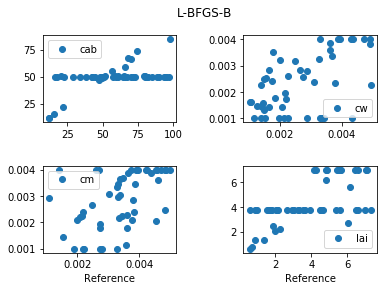

In [ ]:
#quick visual check 

fig, axs = plt.subplots(2,2)
fig.suptitle('L-BFGS-B')
fig.subplots_adjust(wspace=.5,hspace=.5)

#plt.subplot(3,1,1)
axs[0,0].plot(pd_traits3000["cab"],np_lbfgs[:,0],"o",label="cab")
axs[0,0].legend(loc="best")
#axs[0,0].set_xlabel("Reference")

axs[0,1].plot(pd_traits3000["cw"],np_lbfgs[:,1],"o",label="cw")
axs[0,1].legend(loc="best")
#axs[1].set_ylabel("Prediction")

axs[1,0].plot(pd_traits3000["cm"],np_lbfgs[:,2],"o",label="cm")
axs[1,0].legend(loc="best")
axs[1,0].set_xlabel("Reference")
#axs[2].set_ylabel("Prediction")

axs[1,1].plot(pd_traits3000["lai"],np_lbfgs[:,3],"o",label="lai")
axs[1,1].legend(loc="best")
axs[1,1].set_xlabel("Reference")
#axs[3].set_ylabel("Prediction")


#SLSQP

Sequential Leaste SQuares PRogramming

In [ ]:
#For one iteration

minimize(cost_spectra_sentinel,test_trait,args=(test_spectra),
                       bounds=bnds2,
                       method="SLSQP",options=shared_opt)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009025260622948629
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 9


     fun: 0.009025260622948629
     jac: array([-4.66683637e-04,  4.13946625e+00,  2.49757493e+00,  2.41863103e-03])
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([4.98711947e+01, 2.09598328e-03, 3.79328884e-03, 2.13810477e+00])

In [ ]:
#making the loop
k=1
for i in range(train_n3000):
  print("running row nr:",k) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_slsqp = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="SLSQP",options=shared_opt)
    np_slsqp=optim_slsqp.x
  if k > 1:
    optim_slsqp = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="SLSQP",options=shared_opt)
    np_slsqp=numpy.vstack((np_slsqp,optim_slsqp.x))

  k = k+1

running row nr: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009025260622948629
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 9
running row nr: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04143499722061002
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 6
running row nr: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011021074262779488
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
running row nr: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010265702401175098
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
running row nr: 5
Optimization terminated successfully.    (Exit mode 0)
          

Text(0.5, 0, 'Reference')

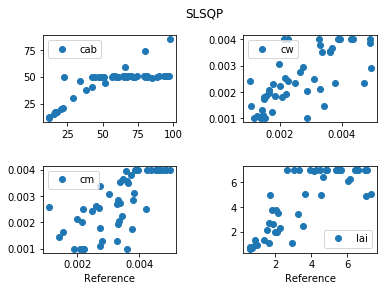

In [ ]:
fig, axs = plt.subplots(2,2)
fig.suptitle('SLSQP')
fig.subplots_adjust(wspace=.5,hspace=.5)

#plt.subplot(3,1,1)
axs[0,0].plot(pd_traits3000["cab"],np_slsqp[:,0],"o",label="cab")
axs[0,0].legend(loc="best")
#axs[0,0].set_xlabel("Reference")

axs[0,1].plot(pd_traits3000["cw"],np_slsqp[:,1],"o",label="cw")
axs[0,1].legend(loc="best")
#axs[1].set_ylabel("Prediction")

axs[1,0].plot(pd_traits3000["cm"],np_slsqp[:,2],"o",label="cm")
axs[1,0].legend(loc="best")
axs[1,0].set_xlabel("Reference")
#axs[2].set_ylabel("Prediction")

axs[1,1].plot(pd_traits3000["lai"],np_slsqp[:,3],"o",label="lai")
axs[1,1].legend(loc="best")
axs[1,1].set_xlabel("Reference")
#axs[3].set_ylabel("Prediction")

# PSO

Particle Swarm Optimization

In [ ]:
from pyswarm import pso

In [ ]:
from pyswarm import pso
np.set_printoptions(suppress=False) 

#running for one iteration
optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[test_spectra],
                swarmsize=1) #it requires a np.array inside a np.array

swarm_size = 150


Stopping search: Swarm best objective change less than 1e-08


In [ ]:
#making the loop
k=1
for i in range(train_n3000):
  print("running row nr:",k) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[np_optim_spectr[i,:]],
                swarmsize=swarm_size)#, #if we change this to 1 i reckon its the same as SGD
                #minfunc=0.00001) #this is important.. but i want the swarm to go faster
    
    np_pso=optim_pso[0]
  if k > 1:
    optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[np_optim_spectr[i,:]],
                swarmsize=swarm_size)#,
                #minfunc=0.00001)
    
    np_pso=numpy.vstack((np_pso,optim_pso[0]))

  k = k+1

running row nr: 1
Stopping search: Swarm best objective change less than 1e-08
running row nr: 2
Stopping search: Swarm best objective change less than 1e-08
running row nr: 3
Stopping search: Swarm best objective change less than 1e-08
running row nr: 4
Stopping search: Swarm best objective change less than 1e-08
running row nr: 5
Stopping search: Swarm best objective change less than 1e-08
running row nr: 6
Stopping search: Swarm best objective change less than 1e-08
running row nr: 7
Stopping search: Swarm best objective change less than 1e-08
running row nr: 8
Stopping search: Swarm best objective change less than 1e-08
running row nr: 9
Stopping search: Swarm best objective change less than 1e-08
running row nr: 10
Stopping search: Swarm best objective change less than 1e-08
running row nr: 11
Stopping search: Swarm best objective change less than 1e-08
running row nr: 12
Stopping search: Swarm best objective change less than 1e-08
running row nr: 13
Stopping search: Swarm best ob

Text(0.5, 0, 'Reference')

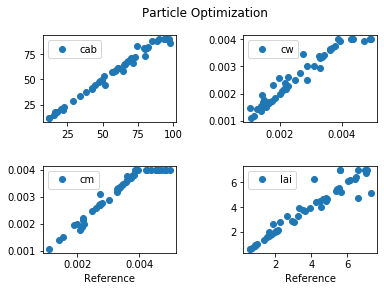

In [ ]:
#Quick plotting

fig, axs = plt.subplots(2,2)
fig.suptitle('Particle Optimization')
fig.subplots_adjust(wspace=.5,hspace=.5)

#plt.subplot(3,1,1)
axs[0,0].plot(pd_traits3000["cab"],np_pso[:,0],"o",label="cab")
axs[0,0].legend(loc="best")
#axs[0,0].set_xlabel("Reference")

axs[0,1].plot(pd_traits3000["cw"],np_pso[:,1],"o",label="cw")
axs[0,1].legend(loc="best")
#axs[1].set_ylabel("Prediction")

axs[1,0].plot(pd_traits3000["cm"],np_pso[:,2],"o",label="cm")
axs[1,0].legend(loc="best")
axs[1,0].set_xlabel("Reference")
#axs[2].set_ylabel("Prediction")

axs[1,1].plot(pd_traits3000["lai"],np_pso[:,3],"o",label="lai")
axs[1,1].legend(loc="best")
axs[1,1].set_xlabel("Reference")
#axs[3].set_ylabel("Prediction")

# Genetic optimization

Differential evolution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution

In [ ]:
from scipy import optimize

optimize.differential_evolution(cost_spectra_sentinel,args=[test_spectra],
                                bounds=bnds2,popsize=4,maxiter=500,recombination=.25,
                                seed=0,init='latinhypercube')


     fun: 2.0047462056687076e-07
     jac: array([0.2203084 , 9.00024867, 3.70108098, 0.        ])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 8096
     nit: 500
 success: False
       x: array([5.93931268e+01, 3.28076576e-03, 3.71126927e-03, 1.54614502e+00])

In [ ]:
np_difevo = optimize.differential_evolution(cost_spectra_sentinel,args=[test_spectra],
                                bounds=bnds2,popsize=4,maxiter=500,recombination=.25,
                                seed=0,init='latinhypercube')

In [ ]:
print(np_difevo.x.shape)
np_pso.shape

(4,)


(50, 4)

In [ ]:
#making the loop
k=1
for i in range(train_n3000):
  print("running row nr:",k) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_diffevo = optimize.differential_evolution(cost_spectra_sentinel,
                                                    args=[np_optim_spectr[i,:]],
                                                    bounds=bnds2,seed=0)
    
    np_diffevo=optim_diffevo.x
  if k > 1:
    optim_diffevo = optimize.differential_evolution(cost_spectra_sentinel,
                                                    args=[np_optim_spectr[i,:]],
                                                    bounds=bnds2,seed=0)
    
    np_diffevo=numpy.vstack((np_diffevo,optim_diffevo.x))

  k = k+1


running row nr: 1
running row nr: 2
running row nr: 3
running row nr: 4
running row nr: 5
running row nr: 6
running row nr: 7
running row nr: 8
running row nr: 9
running row nr: 10
running row nr: 11
running row nr: 12
running row nr: 13
running row nr: 14
running row nr: 15
running row nr: 16
running row nr: 17
running row nr: 18
running row nr: 19
running row nr: 20
running row nr: 21
running row nr: 22
running row nr: 23
running row nr: 24
running row nr: 25
running row nr: 26
running row nr: 27
running row nr: 28
running row nr: 29
running row nr: 30
running row nr: 31
running row nr: 32
running row nr: 33
running row nr: 34
running row nr: 35
running row nr: 36
running row nr: 37
running row nr: 38
running row nr: 39
running row nr: 40
running row nr: 41
running row nr: 42
running row nr: 43
running row nr: 44
running row nr: 45
running row nr: 46
running row nr: 47
running row nr: 48
running row nr: 49
running row nr: 50


Text(0.5, 0, 'Reference')

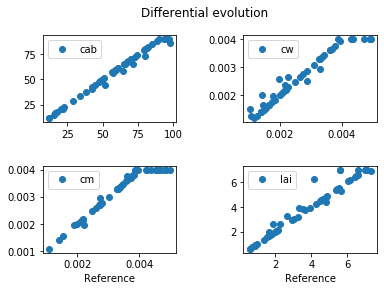

In [ ]:
#Quick plotting

fig, axs = plt.subplots(2,2)
fig.suptitle('Differential evolution')
fig.subplots_adjust(wspace=.5,hspace=.5)

#plt.subplot(3,1,1)
axs[0,0].plot(pd_traits3000["cab"],np_diffevo[:,0],"o",label="cab")
axs[0,0].legend(loc="best")
#axs[0,0].set_xlabel("Reference")

axs[0,1].plot(pd_traits3000["cw"],np_diffevo[:,1],"o",label="cw")
axs[0,1].legend(loc="best")
#axs[1].set_ylabel("Prediction")

axs[1,0].plot(pd_traits3000["cm"],np_diffevo[:,2],"o",label="cm")
axs[1,0].legend(loc="best")
axs[1,0].set_xlabel("Reference")
#axs[2].set_ylabel("Prediction")

axs[1,1].plot(pd_traits3000["lai"],np_diffevo[:,3],"o",label="lai")
axs[1,1].legend(loc="best")
axs[1,1].set_xlabel("Reference")
#axs[3].set_ylabel("Prediction")

# Bayesian optimization

[BayesianOptimization package](https://github.com/fmfn/BayesianOptimization)

[another example](http://philipperemy.github.io/visualization/)

- If needed implement a scaling function for the input data

for a deep implementation
http://krasserm.github.io/2018/03/21/bayesian-optimization/



In [ ]:
from bayes_opt import BayesianOptimization
import math

This package version requires specific changes, here we go

In [ ]:
#This version of Bayes opt requires specific changes

#First the function can no longer take as input a spectra profile, instead it must iterate without being callable

#non-scaled function
rho_s2_temp = test_spectra
def bayes_cost_s2(cab,cw,cm,lai):

  sim_canopy = custom_prosail(cab,cw,cm,lai)
  sim_canopy = Prosail2S2(filepath,sim_canopy)
  sim_canopy = sim_canopy[[1,2,3,4,5,6,8,11,12],]
  #print(rho_s2_temp)
  samerror            = sptool.distance.SAM(rho_s2_temp,sim_canopy)

  #the other important difference is that this package maximizes instead of minimizing
  #we can just make the function output be 1/samerror - as samerror goes to 0, 1 can get infinitely bigger
  #if we want to limit the growth, we can just log the function above (maximizes in 1)

  #return 1-samerror
  return -samerror

#testing the cost function
print(bayes_cost_s2(20,.005,.005,3))
print(bayes_cost_s2(pd_traits3000["cab"][0],pd_traits3000["cw"][0],pd_traits3000["cm"][0],pd_traits3000["lai"][0]))

#now we have also to change the way we set up the boundaries of the bayesian optimization
lb = [min_cab,min_cw,min_cm,min_lai]
ub = [max_cab,max_cw,max_cm,max_lai]

pbounds= {'cab': (min_cab,max_cab),'cw':(min_cw,max_cw),
          'cm':(min_cm,max_cm),'lai':(min_lai,max_lai)}





-0.1740238595481179
-0.0


Testing for the first row and a pre-set number of iterations

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

#testing for one iteration
optim_bayes = BayesianOptimization(
    f=bayes_cost_s2,
    pbounds=pbounds,
    random_state=0,
    #verbose=0
)

#basic usage
optim_bayes.maximize(
    init_points=5,
    n_iter=5,
    acq='poi')



|   iter    |  target   |    cab    |    cm     |    cw     |    lai    |
-------------------------------------------------------------------------
|  1        | -0.06553  |  53.91    |  0.003146 |  0.002808 |  4.042    |
|  2        | -0.06634  |  43.89    |  0.002938 |  0.002313 |  6.297    |
|  3        | -0.1101   |  87.09    |  0.00215  |  0.003375 |  3.938    |
|  4        | -0.09412  |  55.44    |  0.003777 |  0.001213 |  1.066    |
|  5        | -0.1915   |  11.62    |  0.003498 |  0.003334 |  6.155    |
|  6        | -0.06281  |  50.19    |  0.003366 |  0.001692 |  6.339    |
|  7        | -0.09741  |  52.22    |  0.00149  |  0.00381  |  5.697    |
|  8        | -0.05144  |  49.82    |  0.003428 |  0.001    |  6.368    |
|  9        | -0.06589  |  49.32    |  0.003453 |  0.001837 |  6.376    |
|  10       | -0.04406  |  42.8     |  0.002358 |  0.001    |  6.484    |


Testing until it finds a decent solution

In [ ]:

#resets the bayesian optimization
optim_bayes = BayesianOptimization(
    f=bayes_cost_s2,
    pbounds=pbounds,
    random_state=0,
    verbose=0
)

#starts the optimization with 50 random points and 0 iterations
optim_bayes.maximize(
    init_points=300,
    n_iter=0,
    acq='poi')

max_val = 0 #(the maximum value of the current cost function is 0)
tgt_val = optim_bayes.max['target'] #fetches the current target value

k = 1 #this is a safety valve to set a max of iteration
while (abs(tgt_val-max_val)>.001):

  optim_bayes.maximize(
  init_points=0,
  n_iter=1,
  acq='poi')

  tgt_val = optim_bayes.max['target']
  print(k)
  k=k+1
  if (k==25): tgt_val = max_val





1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
optim_bayes.max['target']
tgt_val

0

In [ ]:
optim_bayes.maximize(
    init_points=0,
    n_iter=1,
    acq='poi')
tgt_val = optim_bayes.max
tgt_val['target']


|   iter    |  target   |    cab    |    cm     |    cw     |    lai    |
-------------------------------------------------------------------------
|  8        | -0.04957  |  48.21    |  0.003309 |  0.003502 |  2.603    |


-0.01195881431864231

In [ ]:
#this part is just a test to see how the outputs can be accessed
print(optim_bayes.max['params']['cab'])
bb = np.array([optim_bayes.max['params']['cab'],optim_bayes.max['params']['cab'],optim_bayes.max['params']['cab'],optim_bayes.max['params']['cab']])
optim_diffevo.x
bb

42.7951524906278


array([42.79515249, 42.79515249, 42.79515249, 42.79515249])

In [ ]:

#initial set of points
init_point_set = 10
max_iter_bayes = 30


k=1
for i in range(train_n3000):
  print("running row nr:",k) #uncomment if you want to keep track of what is going on

  #first we update the spectra
  rho_s2_temp = np_optim_spectr[i,:]

  #let's see if this changes the within value of the function
  #so we stabilize the input to the bayes but we iterate the target spectra
  #print(bayes_cost_s2(pd_traits3000["cab"][0],pd_traits3000["cw"][0],pd_traits3000["cm"][0],pd_traits3000["lai"][0]))
  #print(bayes_cost_s2(pd_traits3000["cab"][i],pd_traits3000["cw"][i],pd_traits3000["cm"][i],pd_traits3000["lai"][i]))

  #now we initialize an optimizer per row

  optim_bayes = BayesianOptimization(
    f=bayes_cost_s2,
    pbounds=pbounds,
    random_state=0,
    verbose=0 #uncomment me to reduce theconsole spam
    )
  
  optim_bayes.maximize(
    init_points=init_point_set,
    n_iter=max_iter_bayes,
    acq='poi') #options are: "ucb"(Default),"ei" and "poi"

  cab_t = optim_bayes.max['params']['cab']
  cw_t = optim_bayes.max['params']['cw']
  cm_t = optim_bayes.max['params']['cm']
  lai_t = optim_bayes.max['params']['lai']
  temp_stack = np.array([cab_t,cw_t,cm_t,lai_t])
  
  #and finally we can jsut throw the output into the a np stack 
  if k == 1:
    np_bayesopti=temp_stack
  if k > 1:
    np_bayesopti=numpy.vstack((np_bayesopti,temp_stack))

  k = k+1

running row nr: 1
running row nr: 2
running row nr: 3
running row nr: 4
running row nr: 5
running row nr: 6
running row nr: 7
running row nr: 8
running row nr: 9
running row nr: 10
running row nr: 11
running row nr: 12
running row nr: 13
running row nr: 14
running row nr: 15
running row nr: 16
running row nr: 17
running row nr: 18
running row nr: 19
running row nr: 20
running row nr: 21
running row nr: 22
running row nr: 23
running row nr: 24
running row nr: 25
running row nr: 26
running row nr: 27
running row nr: 28
running row nr: 29
running row nr: 30
running row nr: 31
running row nr: 32
running row nr: 33
running row nr: 34
running row nr: 35
running row nr: 36
running row nr: 37
running row nr: 38
running row nr: 39
running row nr: 40
running row nr: 41
running row nr: 42
running row nr: 43
running row nr: 44
running row nr: 45
running row nr: 46
running row nr: 47
running row nr: 48
running row nr: 49
running row nr: 50


Text(0.5, 0, 'Reference')

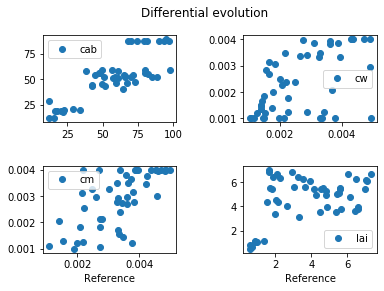

In [ ]:
#Quick plotting
fig, axs = plt.subplots(2,2)
fig.suptitle('Differential evolution')
fig.subplots_adjust(wspace=.5,hspace=.5)

#plt.subplot(3,1,1)
axs[0,0].plot(pd_traits3000["cab"],np_bayesopti[:,0],"o",label="cab")
axs[0,0].legend(loc="best")
#axs[0,0].set_xlabel("Reference")

axs[0,1].plot(pd_traits3000["cw"],np_bayesopti[:,1],"o",label="cw")
axs[0,1].legend(loc="best")
#axs[1].set_ylabel("Prediction")

axs[1,0].plot(pd_traits3000["cm"],np_bayesopti[:,2],"o",label="cm")
axs[1,0].legend(loc="best")
axs[1,0].set_xlabel("Reference")
#axs[2].set_ylabel("Prediction")

axs[1,1].plot(pd_traits3000["lai"],np_bayesopti[:,3],"o",label="lai")
axs[1,1].legend(loc="best")
axs[1,1].set_xlabel("Reference")
#axs[3].set_ylabel("Prediction")

# Saving everything to drive



In [ ]:
np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_4Traits.csv",
           pd_traits3000.iloc[:,:].values,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_4Traits_S2Spectra.csv",
           np_optim_spectr,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_Pred_LBFGSB.csv",
           np_lbfgs,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_Pred_SLSQP.csv",
           np_slsqp,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_Pred_pso.csv",
           np_pso,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_Pred_diffevo.csv",
           np_diffevo,
           delimiter=";")

np.savetxt("/content/drive/My Drive/DSRP_Lunch_outputs/Optim_Pred_BayesOpt.csv",
           np_bayesopti,
           delimiter=";")
